# Importing the Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

!pip install gensim # Gensim is an open-source library for unsupervised topic modeling and natural language processing
import nltk
nltk.download('punkt')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.corpus import stopwords
import seaborn as sns 
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv
[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


# Reading the Dataset

In [2]:
df_true = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv")
df_fake = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv")

**Setting up a target variable and combining both the real and fake news datasets**

In [3]:
df_true['target'] = 1
df_fake['target'] = 0
df = pd.concat([df_true, df_fake]).reset_index(drop = True)
df['original'] = df['title'] + ' ' + df['text']
df.head()

,title,text,subject,date,target,original
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,Trump wants Postal Service to charge 'much mor...


**Lets take a note of the null values in the data**

In [4]:
df.isnull().sum()

title       0
text        0
subject     0
date        0
target      0
original    0
dtype: int64

# Data Cleaning

In [5]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)
            
    return result

In [6]:
# Transforming the unmatching subjects to the same notation
df.subject=df.subject.replace({'politics':'PoliticsNews','politicsNews':'PoliticsNews'})

In [7]:
sub_tf_df=df.groupby('target').apply(lambda x:x['title'].count()).reset_index(name='Counts')
sub_tf_df.target.replace({0:'False',1:'True'},inplace=True)
fig = px.bar(sub_tf_df, x="target", y="Counts",
             color='Counts', barmode='group',
             height=400)
fig.show()

**Observation** The dataset looks really balanced and hence working on this is pretty easy. Thus we need not work on to make this dataset more balanced, and can safely assume this is a balanced dataset

In [8]:
sub_check=df.groupby('subject').apply(lambda x:x['title'].count()).reset_index(name='Counts')
fig=px.bar(sub_check,x='subject',y='Counts',color='Counts',title='Count of News Articles by Subject')
fig.show()

**Observations** Political News and World News hold the most domination counts in the data set that we have considered.

In [9]:
df['clean_title'] = df['title'].apply(preprocess)
df['clean_title'][0]

['budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script']

In [10]:
df['clean_joined_title']=df['clean_title'].apply(lambda x:" ".join(x))

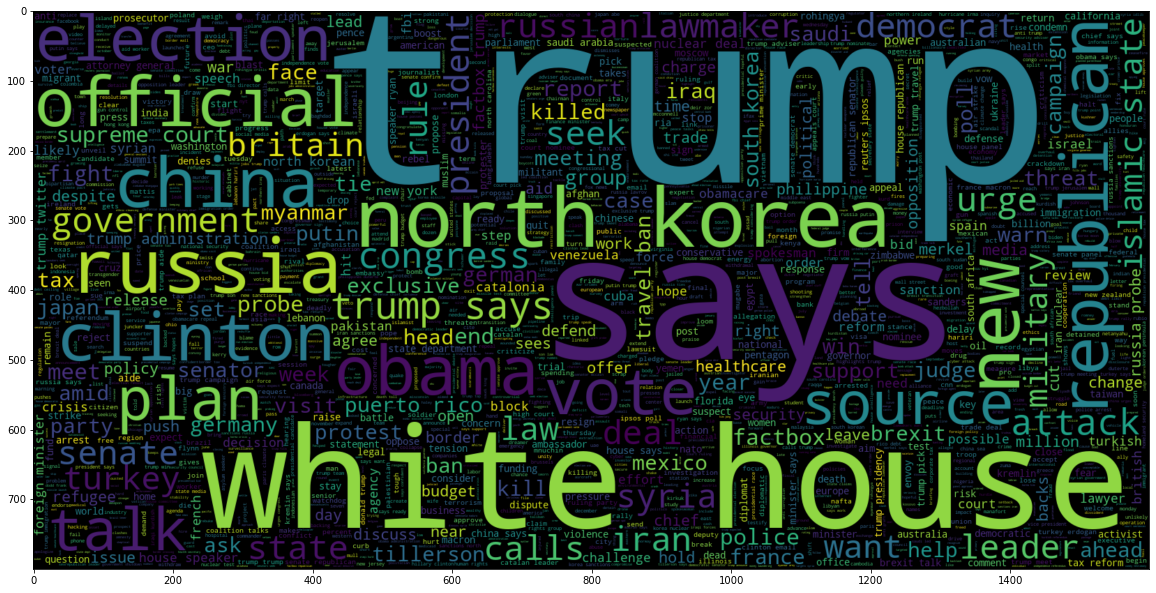

In [11]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 1].clean_joined_title))
plt.imshow(wc, interpolation = 'bilinear')

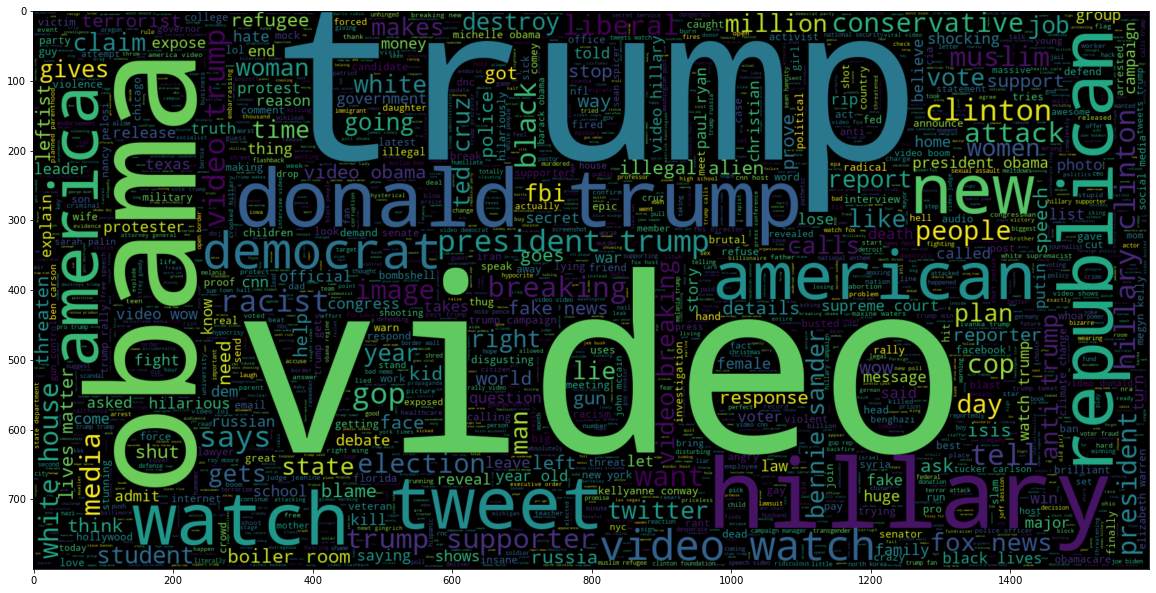

In [12]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 0].clean_joined_title))
plt.imshow(wc, interpolation = 'bilinear')

In [13]:
maxlen = -1
for doc in df.clean_joined_title:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in a title is =", maxlen)
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined_title], nbins = 50)
fig.show()

The maximum number of words in a title is = 34


**Observation:** On an average, The maximum number of titles range between 7-8 words. Would be a bit tricky to judge if the news if true or fake only with these few words. So we hope we shall not be getting a great amount of accuracy using the title alone. Still lets move on to our prediction

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df.clean_joined_title, df.target, test_size = 0.2,random_state=2)
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)
X_vec_test = vec_train.transform(X_test)

In [15]:
model = LogisticRegression(C=2)
model.fit(X_vec_train, y_train)
predicted_value = model.predict(X_vec_test)
accuracy_value = roc_auc_score(y_test, predicted_value)
print(accuracy_value)

0.9475943910154114


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



**Observations** Damn! 94.75% accuarte prediction is quite a good result (Didn't expect it though :P). Now lets take a look at the confusion Matrix for this model using just the title

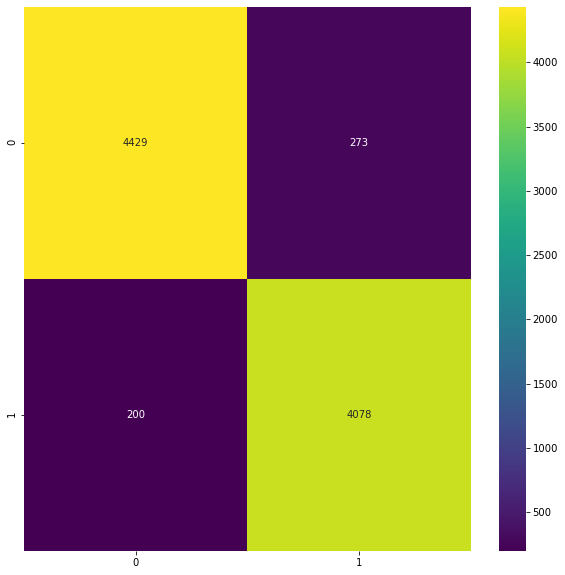

In [16]:
cm = confusion_matrix(list(y_test), predicted_value)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='g',cmap='viridis')

**Observations** 4465 Fake News have been Classified as Fake, while 4045 Real News have been classified as Real! Well Done! But we see we still have 470 titles that are misleading and are classified wrong.

In [17]:
df['clean_text'] = df['text'].apply(preprocess)
df['clean_joined_text']=df['clean_text'].apply(lambda x:" ".join(x))

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 1].clean_joined_text))
plt.imshow(wc, interpolation = 'bilinear')

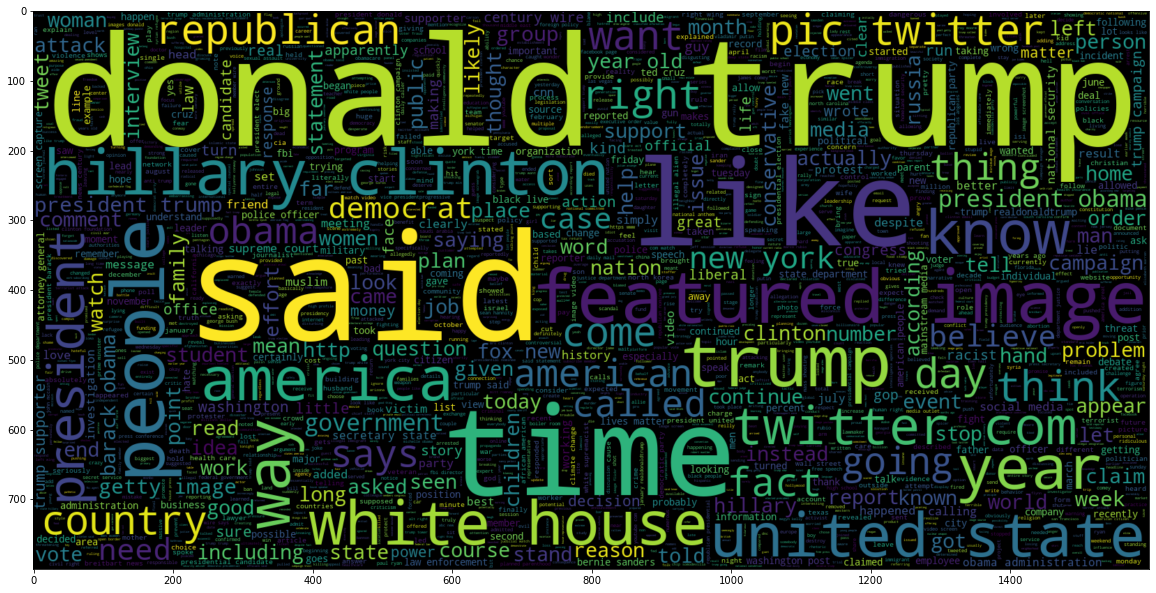

In [19]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 0].clean_joined_text))
plt.imshow(wc, interpolation = 'bilinear')

In [20]:
maxlen = -1
for doc in df.clean_joined_text:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in a News Content is =", maxlen)
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined_text], nbins = 50)
fig.show()

The maximum number of words in a News Content is = 4573


**Observation** As we can see most of the News articles are within a range of 100-200 words. Anything beyond this point is not very catchy, and even the mdia tends to avoid. But yes when the number of words are such large, it will be much easier for the model to predict. We hope the newer accuracy is much more than the Title model. Lets check it out in our next section

In [21]:

X_train, X_test, y_train, y_test = train_test_split(df.clean_joined_text, df.target, test_size = 0.2,random_state=2)
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)
X_vec_test = vec_train.transform(X_test)
model = LogisticRegression(C=2.5)
model.fit(X_vec_train, y_train)
predicted_value = model.predict(X_vec_test)
accuracy_value = roc_auc_score(y_test, predicted_value)
print(accuracy_value)

0.9953661308915527


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



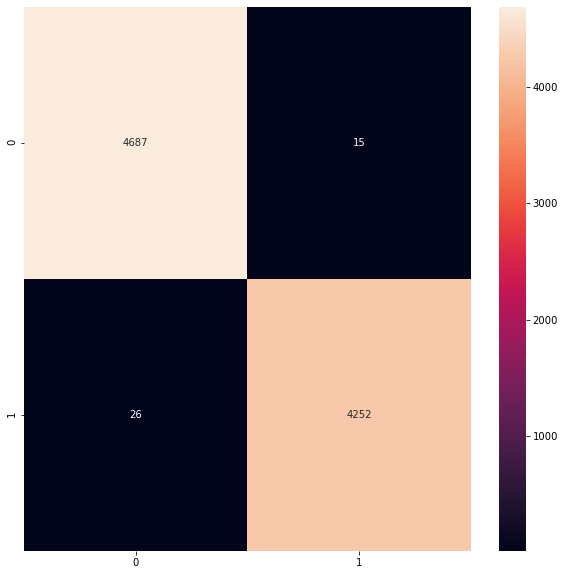

In [22]:
prediction = []
for i in range(len(predicted_value)):
    if predicted_value[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='g')

**Observation** This is Awesome! 4662 Contents of Fake News were classified as Fake, while 4281 Real ones were rightly predicted as well. Now we have only 41 missclassified sets. Massive improvement from our first model. But can we try to improve this any further?
What if, we combine the title and content, would it give us any better result- No harm in trying. Lets check that out in the following section

In [ ]:
df['clean_final'] = df['original'].apply(preprocess)
df['clean_joined_final']=df['clean_final'].apply(lambda x:" ".join(x))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.clean_joined_final, df.target, test_size = 0.2,random_state=0)
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)
X_vec_test = vec_train.transform(X_test)
model = LogisticRegression(C=3)
model.fit(X_vec_train, y_train)
predicted_value = model.predict(X_vec_test)
accuracy_value = roc_auc_score(y_test, predicted_value)
print(accuracy_value)

**Observation** 99.67%!!! Quite Perfect Score! So considering both the title and the content of the news we have been able to predict the nature of the news! For our final consolation, lets take a look at the confusion matrix!

In [ ]:
prediction = []
for i in range(len(predicted_value)):
    if predicted_value[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='g',cmap='inferno')

# Conclusion

We have been succesfully able to reach the target for classifying a News- and are able to identify if this is a True or Fake. However would like to highligh ton a few points as mentioned below:
1. Its not much feasible to predict the news just from its title. **"Titles are misleading!!"**
2. A much better Idea was obtained when we considered the article context for the News. The accuracy percentages shot up from 94% to 99+%. Drastic Improvement it is!
3. Considering both the title and the context, we have been able to reach the highest percentages of accuracy. I shall be working on to implement further models that would give even better results.